<a href="https://colab.research.google.com/github/langmusi/Predictive-Modeling/blob/main/Topic_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bertopic
!pip install bertopic[visualization]

In [2]:
from bertopic import BERTopic

In [4]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Reading Data

In [ ]:
df = pd.read_csv('/content/open_dmg_4.csv', sep = ';')   # open_dmg_subset_eventcode.csv  # open_dmg_2
print(df.shape)
df.head()

In [ ]:
df.loc[df.Text == '  ']
#df.loc[[2]]
#df['Text'].iloc[2]

In [ ]:
df = df.loc[df.Text != '  ']
df.shape
df

In [8]:
text = df['Text'].tolist()

### Checking Max Length of the Sentences

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('KB/electra-small-swedish-cased-generator')
max_len = 0

# For every sentence...
for sent in text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    
    # Update the minimum sentence length

print('Max sentence length: ', max_len)


Max sentence length:  158


# Topic Modeling

In [ ]:
#topic_model = BERTopic(embedding_model=model, calculate_probabilities=True, nr_topics="auto") 
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator
topic_model = BERTopic(embedding_model=model, calculate_probabilities=True, nr_topics=15) 

In [ ]:
topics, probs = topic_model.fit_transform(text)

In [ ]:
# Further reduce topics
new_topics, new_probs = topic_model.reduce_topics(text, topics, probabilities=probs, nr_topics=30)

In [ ]:
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} texts have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} texts are {topic_freq['Topic'].shape[0]-1} topics")

In [ ]:
topic_freq 

In [ ]:
df_sub_dat_eventcode = df.copy()
print(df_sub_dat_eventcode.shape)
# df_whole_dat.drop("Text", axis=1, inplace=True)
# df_whole_dat.shape

In [ ]:
#len(topics)
df_whole_dat['kb_sv_base_Topics'] = topics
#df_whole_dat.drop('Topics', axis=1, inplace=True)
df_whole_dat.head()

In [ ]:
df_sub_dat_eventcode.to_csv('./bert_topics_brakeSystem_subdat_eventcode_allmodels.csv',
                         decimal = ",", header = True, index = False, sep = ";", encoding = "utf-8-sig")

In [ ]:
df_sub_dat_eventcode['roberta_Topics'] = topics
#df_whole_dat.drop('Topics', axis=1, inplace=True)
df_sub_dat_eventcode.head()

# HDBSCAN

### SentenceTransformers Sentence-embedding

In [ ]:
!pip install -U sentence-transformers

In [10]:
from sentence_transformers import SentenceTransformer

In [ ]:
#topic_model = BERTopic(embedding_model=model, calculate_probabilities=True, nr_topics="auto") 
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator

model_st = SentenceTransformer("af-ai-center/bert-large-swedish-uncased")  # stsb-xlm-r-multilingual

Exception when trying to download http://sbert.net/models/af-ai-center/bert-large-swedish-uncased.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/af-ai-center/bert-large-swedish-uncased.zip not found. Try to create it from scratch
Try to create Transformer Model af-ai-center/bert-large-swedish-uncased with mean pooling


Some weights of the model checkpoint at af-ai-center/bert-large-swedish-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(model_st.max_seq_length)

None


In [ ]:
# https://www.sbert.net/examples/applications/computing-embeddings/README.html
model_st.max_seq_length = 158

sentence_embeddings = model_st.encode(text, normalize_embeddings=True, show_progress_bar=True)
sentence_embeddings.shape
len(sentence_embeddings[0])

(1223, 256)

256

In [ ]:
for sentence, embedding in zip(text[:2], sentence_embeddings[0:2]):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

### Dimension Reduction

Why is dimensionality reduction always done before clustering? - https://stats.stackexchange.com/questions/256172/why-is-dimensionality-reduction-always-done-before-clustering

R: https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6: Graph-based clustering (Spectral, SNN-cliq, Seurat) is perhaps most robust for high-dimensional data as it uses the distance on a graph.

(From the same article as the above link shows)HDBSCAN, i.e. Hierarchical DBSCAN, is a powerful density-based clustering algorithm which is: 1) indifferent to the shape of clusters, 2) does not require the number of clusters to be specified, 3) robust with respect to clusters with different density. Further, HBDSCAN is very attractive because it has only one hyperparameter minPts which is the minimal number of points in a cluster. It is relatively fast for large data sets, detects outlying cells, and for each cell it reports a probability of assignment to a cluster.

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE. - https://www.scikit-yb.org/en/latest/api/text/tsne.html

#### UMAP

Uniform Manifold Approximation and Projection for Dimension Reduction

In [ ]:
import umap

In [ ]:
# https://umap-learn.readthedocs.io/en/latest/sparse.html A text analysis example
reducer = umap.UMAP(metric='hellinger', random_state=42)
reducer.fit(sentence_embeddings)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1,
     n_neighbors=15, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)

In [ ]:
umap_embedding = reducer.transform(sentence_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(umap_embedding == reducer.embedding_))
umap_embedding.shape

(1223, 2)

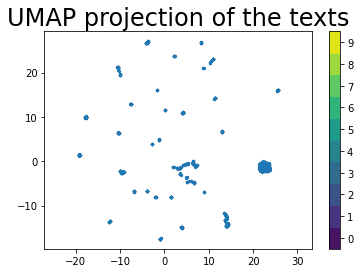

In [ ]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the texts', fontsize=24);

## HDBSCAN

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

In [ ]:
import hdbscan
import sklearn.cluster as cluster
import time
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

#from sklearn.preprocessing import StandardScaler 

In [ ]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

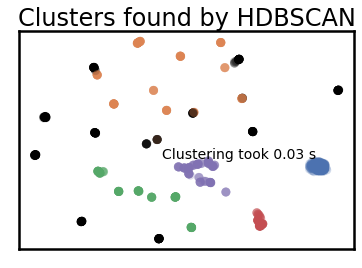

In [ ]:
plot_clusters(umap_embedding, hdbscan.HDBSCAN, (), {'min_cluster_size':50})

In [ ]:
plot_clusters(sentence_embeddings, hdbscan.HDBSCAN, (), {'min_cluster_size':50})

In [ ]:
plot_clusters(umap_embedding, cluster.SpectralClustering, (), {'n_clusters':6})

In [ ]:
plot_clusters(umap_embedding, cluster.DBSCAN, (), {'eps':5.25})

In [ ]:
# Increasing the min_cluster_size to 30 reduces the number of clusters, merging some together.
# The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas. 
# Leaf clustering: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True, cluster_selection_method='leaf')

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='leaf', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
        prediction_data=False)

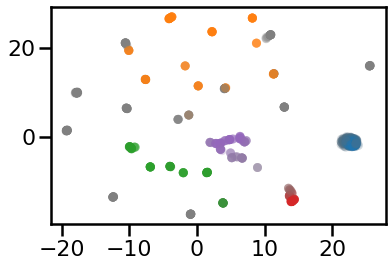

In [ ]:
clusterer.fit(umap_embedding)

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
#cluster_colors
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_colors, **plot_kwds)

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='leaf', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
        prediction_data=False)

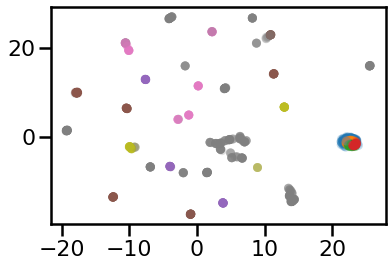

In [ ]:
clusterer.fit(sentence_embeddings)

palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
#cluster_colors
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_colors, **plot_kwds)

In [ ]:
clusterer.labels_

array([ 1, -1,  0, ...,  0,  0,  0])

## Custom Function for All Models

In [ ]:
def mycluster(text_list, bert_model, custom_mincluster_size, custom_max_seq_length = 160):
  
  # sentence embedding
  model_st = SentenceTransformer(bert_model) 
  model_st.max_seq_length = custom_max_seq_length
  sentence_embeddings = model_st.encode(text_list, normalize_embeddings=True, show_progress_bar=True)

  # dimension reduction
  reducer = umap.UMAP(random_state=42, metric='cosine')
  reducer.fit(sentence_embeddings)

  # clustering HDBSCAN
  clusterer = hdbscan.HDBSCAN(min_cluster_size=custom_mincluster_size, gen_min_span_tree=True, cluster_selection_method='leaf')
  clusterer.fit(sentence_embeddings)

  unique_value = np.unique(clusterer.labels_)

  return clusterer.labels_, unique_value


In [ ]:
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator

elec_cluster, elec_unique_cluster = mycluster(text, bert_model="KB/electra-small-swedish-cased-generator",
                                       custom_mincluster_size = 30)
#elec_cluster
elec_unique_cluster

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [ ]:
#topic_model = BERTopic(embedding_model="KB/bert-base-swedish-cased", calculate_probabilities=True, nr_topics = 30) 
# model

# af-ai-center/bert-large-swedish-uncased
# KB/electra-small-swedish-cased-generator

af_cluster, af_unique_cluster = mycluster(text, bert_model="af-ai-center/bert-large-swedish-uncased",
                                       custom_mincluster_size = 30)
#af_cluster
af_unique_cluster

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [ ]:
bert_base_cluster, bb_unique_cluster = mycluster(text, bert_model="KB/bert-base-swedish-cased",
                                                 custom_mincluster_size = 30)

bert_base_cluster
bb_unique_cluster

array([-1,  6,  4, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  3, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  5, -1,
        1,  5, -1,  6,  6, -1,  2,  2, -1, -1,  0, -1,  0,  5,  5,  5,  5,
        5,  5,  6, -1,  6, -1, -1, -1, -1,  3,  3,  2,  2,  2,  9, -1, -1,
        6,  6,  3,  8,  8,  8,  8,  8, -1,  8,  8, -1,  3,  1,  3,  3,  3,
        4,  6,  6,  6,  6, -1,  2, -1,  7,  1,  4,  4,  4,  2,  2,  1,  2,
        7, -1, -1, -1,  1, -1,  3, -1,  0,  0, -1,  3,  3,  0, -1, -1,  6,
       -1, -1,  3,  3, -1, -1,  5, -1,  5,  7,  2,  3,  2, -1, -1,  1, -1,
       -1,  3,  3,  0,  0,  5,  3,  5, -1, -1,  5,  6, -1, -1, -1,  0, -1,
        6, -1,  2,  2,  9,  4,  9,  8,  3,  0,  9,  9,  9, -1, -1,  6,  6,
        6,  6, -1,  3,  0,  8,  8,  8,  8,  8,  8, -1,  6,  8,  3,  4,  3,
        0,  7,  4,  6,  6,  6,  4, -1,  4,  4, -1,  4,  8,  4,  4,  6,  8,
       -1,  3, -1,  6,  7,  6,  2,  2, -1, -1, -1,  7, -1,  0,  4,  6,  2,
        2,  3,  7, -1,  7

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [ ]:
df['af_cluster'] = af_cluster
df['elec_cluster'] = elec_cluster
df['bert_base_cluster'] = bert_base_cluster
df

,TrainsetVehicleNumber,DefectHeading,DefectDescription,FaultIndicationCode,DefectCode,DefectNumber,Text,elec_cluster,af_cluster,bert_base_cluster
0,X61005,NaN,bromsen avstånd boogie epac fastbromsningsskyd...,NaN,51,17048150,"Broms: EPAC 5, fastbromsningsskydd felaktigt",-1,-1,-1
1,X61032,3920; broms vagn a1: avstängningskran för nödb...,3920; broms vagn a1: avstängningskran för nödb...,NaN,51,15171713,Broms vagn A1: Avstängningskran för nödbroms ...,5,6,6
3,X61007,felkod 3501. broms vagn a2: epac felaktig fele...,felkod 3501. broms vagn a2: epac felaktig fele...,NaN,51,15054079,Broms vagn A2: EPAC 4 felaktig,7,4,4
12,X61068,13522 multipelfel bromsfel tågnivå bromsstyrenhet,13522 multipelfel bromsfel tågnivå bromsstyrenhet,13522.0,513,18015611,"Multipelfel ""EP bromsfel"" tågnivå",-1,-1,-1
13,X61039,13539 multipelfel parkeringsbroms till fordons...,13539 multipelfel parkeringsbroms till fordons...,13539.0,525,20000252,"Multipelfel ""EP bromsfel"" fordonsnivå Parkerin...",-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
1203,X61011,521 bromsenhet felkoder 2922 och 2923 epac bro...,521 bromsenhet felkoder 2922 och 2923 epac bro...,NaN,521,20059067,Broms M1 EPAC 3: Broms på axel 05 blockerade ...,-1,-1,-1
1206,X61003,avstängd broms boggi felkod 3502,avstängd broms boggi felkod 3502,3502.0,5,18084812,Broms vagn A2: Avstängningskran broms boggie ...,5,6,6
1212,X61003,hållebroms går till under färd från bägge hytt...,felkod 14820 inträffat ggr kort tid. 20: hållb...,NaN,513,16071558,TB 20: Hållbroms ej loss,0,0,1
1218,X61079,avstängningskran nödbroms,"broms vagn a1, avstängningskran för nödbroms s...",NaN,5,17028719,Broms vagn A1: Avstängningskran för nödbroms ...,5,6,6


In [ ]:
df.to_csv('./bert_topics_brakeSystem_models.csv',
          decimal = ",", header = True, index = False, sep = ";", encoding = "utf-8-sig")

In [ ]:
tok = BertTokenizer.from_pretrained("KB/bert-base-swedish-cased")
model = BertForMaskedLM.from_pretrained("KB/bert-base-swedish-cased" if sys.argv[1] == "orig" else "bert_sdm")

In [ ]:
# the following codes do not work
# from transformers import pipeline
 
# fill_mask = pipeline(
#  "fill-mask",
#  model="bert_sdm",
#  tokenizer="bert_sdm"
# )

In [ ]:
x = tok.encode(sys.argv[2])
print(x)

In [ ]:
idx = x.index(115)
x = torch.Tensor([x]).long()

In [ ]:
l = model(x)[0]
l = l[0][idx].detach().cpu().numpy()
la = l.argsort()

for i in range(1, 11):
    print(tok.decode([la[-i]]))

In [ ]:
while True:pass

KeyboardInterrupt: ignored